## Module1: Lending Club Case Study

### Problem Statement: 
> - Understand how consumer attributes and loan attributes influence the tendency of default
> - Understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default

### Sections
> - A. Python imports
> - B. Reading loan dataset
> - C. Analysis
    -   1. Distribution of defaulters in the dataset
    -   2. Categorical Analysis
        - 1. Functions used for analysis
        - 2. Home ownership of defaulters
        - 3. Distribution of verification status of defaulters
        - 4. Employement length of the defaulters
        - 5. Term distribution of defaulters
        - 6. Distribution of annual income of defaulters
        - 7. Loan purpose of defaulters
        - 8. DTI of defaulters
        - 9. Location distribution of defaulters
        - 10. Interest rates of defaulters vs fully paid cases
        - 11. Loan amount distribution of defaulters
        - 12. Overdue behavior of defaulters vs fully paid cases
        - 13. Revolving balance stats of defaulters
    

### Section A: Python imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
import seaborn as sns
import numpy as np
from matplotlib.ticker import PercentFormatter

### B. Read the loan dataset from below - 'loan.csv'
> It contains the complete loan data for all loans issued through the time period 2007 to 2011

In [2]:
df = pd.read_csv('loan.csv', low_memory=False)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### C.1. Get the distribution of defaulters in the dataset

#### Conclusion/Observation
> - About 86% of the members are non-defaulters i.e. either have fully paid off the load or are in paying in time
> - Remaining 14% of the members have defaulted

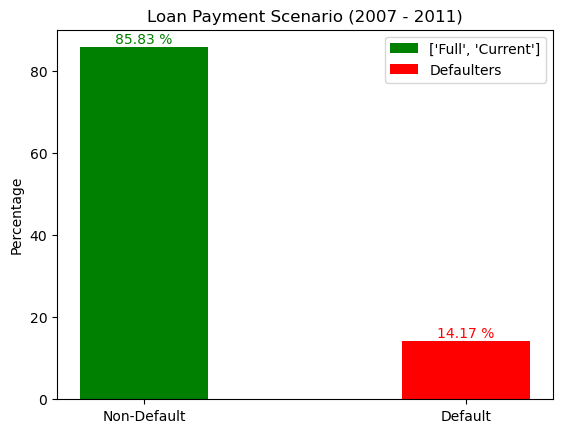

In [3]:
# Getting percentage of charged off
# Get the data on loan status
df_loan_status = df.loc[:, ['loan_status']]
# Number of default cases
num_default = (df_loan_status['loan_status'] == 'Charged Off').sum()
# Number of non-default cases (includes fully paid and currently paying)
non_default = len(df_loan_status.index) - num_default
# Percentage of defaulters
default_per = 100*num_default/len(df_loan_status.index)
# Plots
plt.bar(["Non-Default", "Default"], [100- default_per, default_per], width=0.4, color=['green', 'red'], label=[["Full", "Current"], 'Defaulters'])
plt.ylabel('Percentage')
plt.title('Loan Payment Scenario (2007 - 2011)')
plt.text(0, 100- default_per + 1, "{:3.2f}".format(100- default_per) + " %", ha='center', color='green')
plt.text(1, default_per + 1, "{:3.2f}".format(default_per) + " %", ha='center', color='red')
plt.legend()
plt.show()

### Get the data of Defaulters and Fully Paid members

In [4]:
# Getting details on charged off cases 
df_defaults = df[df['loan_status'] == 'Charged Off']
df_fullyPaid = df[df['loan_status'] == 'Fully Paid']

### C.2 Analysis

### C.2.1 Custom functions
#### 1. Function that plots a specific pattern
##### Function 
> plot_pattern(category_list, col_name, total_rows, title, df)
##### Arguments:
> - category_list: list of categories e.g. rent, mortgage, own, other
> - col_name: column of the data frame on which categorical analysis is peformed
> - total_rows: specify number of rows in the dataframe considered for analysis
> - title: specify title to the patter/categorical analysis
> - df: pandas dataframe

##### 2. Function that gets mean date difference for a specific term
> get_term_wise_mean_date_diff(df)
##### Arguments:
> - df: pandas dataframe

In [5]:
def plot_pattern(category_list, col_name, total_rows, title, df):
    """
    category_list: list of strings; list of categories e.g. rent, mortgage, own, other
    col_name:      string; column of the data frame on which categorical analysis is peformed
    total_rows:    integer; specify number of rows in the dataframe considered for analysis
    title:         string; specify title to the patter/categorical analysis
    df:            pandas dataframe
    """
    perc_array = []
    for status in category_list:
        perc_array.append(100*(df[col_name] == status).sum()/total_rows)  
    plt.bar(category_list, perc_array)
    for i in range(len(category_list)):
        plt.text(i, perc_array[i] + 1, "{:3.2f}".format(perc_array[i]) + " %", ha='center')
    plt.title(title)

In [6]:
def get_term_wise_mean_date_diff(df):
    # Getting data for columns - issue_d, last_paymnt_d, and term
    df_d = df.loc[:, ['issue_d', 'last_pymnt_d', 'term']]
    # Removing null values
    df_d = df_d[~(df_d['last_pymnt_d'].isnull())]
    df_d = df_d[~(df_d['issue_d'].isnull())]
    # Calculate the difference between last payment and issue dates
    df_d['date_diff'] = pd.to_datetime(df_d['last_pymnt_d'], format='%b-%y') - pd.to_datetime(df_d['issue_d'], format='%b-%y')
    # Drop the issue_d and last_paymnt_d columns as they are redundant now
    df_d = df_d.drop(['issue_d', 'last_pymnt_d'], axis=1)
    # Converting date difference string to integers in years
    d_diff = df_d['date_diff'].to_list()
    d_diff = [int(str(s).split(' days')[0])/(30*12) for s in d_diff]
    df_d['date_diff'] = d_diff
    # Return average date difference in years for each term
    return df_d.groupby(by=['term']).mean()

### C.2.2 Home Ownsership of Defaulters

### Conclusions/Observations:
> - About 50% of the defaulters stay in a rented house - from this one can infer that they are either bachelors or have low income if they have family staying with them
> - 41 % of them have mortage and only 8% have their own houses

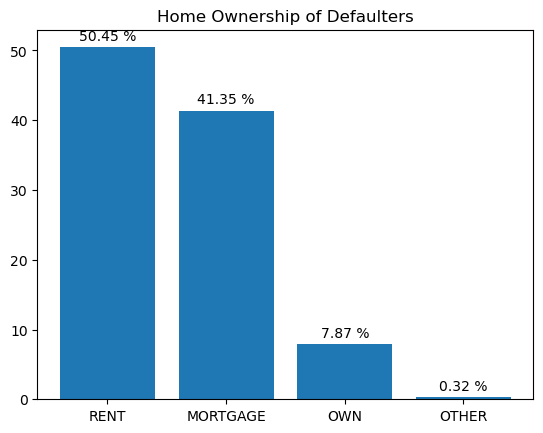

In [7]:
# Looking at home ownership for charged off cases
# Analysing percentage of home ownership for defaulters
plot_pattern(['RENT', 'MORTGAGE', 'OWN', 'OTHER'], 'home_ownership', len(df_defaults.index), "Home Ownership of Defaulters", df_defaults)
plt.show()

### C.2.3 Distribution of verification status of defaulters

### Conclusions/Observations:
> - Defaults seem to occur where either income is verified by LC or not - this would also mean since their income source is not verified, the source of income is not stable enough to repay the loan
> - Defaults occur lesser where the income source is verified

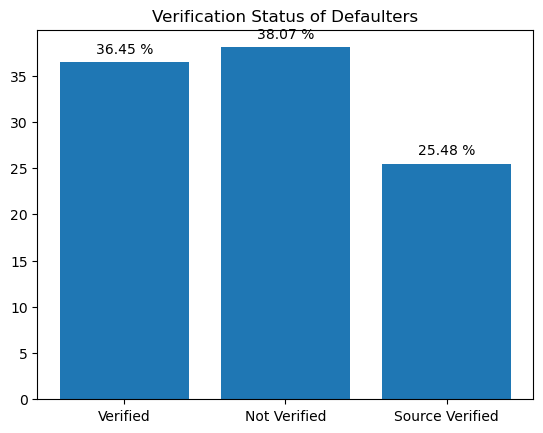

In [8]:
# Looking for cases where if source was verified
plot_pattern(['Verified', 'Not Verified', 'Source Verified'], 'verification_status', len(df_defaults.index), "Verification Status of Defaulters", df_defaults)
plt.show()

### C.2.4 Employement length of the defaulters

### Conclusions/Observations:
> - Generally, the defaults tend to decrease gradually as the members spend more time in the company(s)
> - However there is a shoot up in defaults when employement length is 10 years and more
    - This might be due to the fact that the job is low paying and applied loan is higher and the interest rate goes on increasing and/or they are not getting promoted and expenses are rising

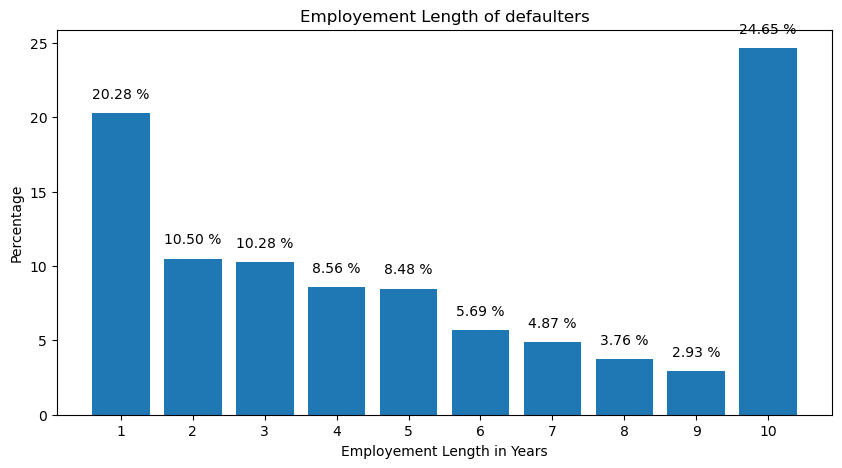

In [9]:
# Employement Length of defaulters
# Removing n/a's and nulls from emp_length column
df_n = df_defaults[(df_defaults['emp_length'] != 'n/a')]
df_n = df_n[~(df_n['emp_length'].isnull())]
e = df_n['emp_length']
# Get the numeric value of employment length from the column
e = [re.findall('\d+', s)[0] for s in e]
df_n['emp_length'] = e
e = list(set(e))
e = [int(s) for s in e]
e.sort()
e = [str(s) for s in e]
# Draw the bar plots
plt.figure(figsize=(10, 5))
plot_pattern(e, 'emp_length', len(df_n.index), "Employement Length of defaulters", df_n)
plt.xlabel('Employement Length in Years')
plt.ylabel("Percentage")
plt.show()

### C.2.5 Term distribution of the defaulters

#### Conclusions/Observations:
> - About 57% of the defaulters chose to go fo 3 years term for the loan assignment

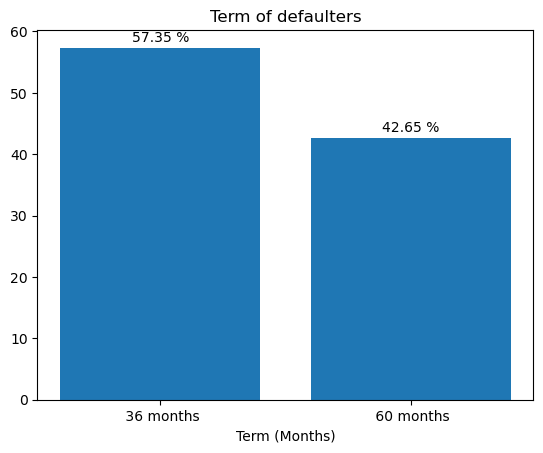

In [10]:
# Term of defaulters
plot_pattern([' 36 months', ' 60 months'], 'term', len(df_defaults.index), "Term of defaulters", df_defaults)
plt.xlabel('Term (Months)')
plt.show()

### C.2.6 Distribution of annual income of defaulters

### Conclusions/Observations:
> - With both 3 and 5 years term plan, most of the defaults happen for annual income up to 1 Lakh per annum

Overall annual income stats (lakhs): 
 count    5627.000000
mean        0.624273
std         0.477760
min         0.040800
25%         0.370000
50%         0.530000
75%         0.750000
max        12.500000
Name: annual_inc, dtype: float64
3 years term annual income stats (lakhs): 
 count    3227.000000
mean        0.591685
std         0.458376
min         0.040800
25%         0.350000
50%         0.500000
75%         0.700000
max         8.400000
Name: annual_inc, dtype: float64
5 years term annual income stats (lakhs): 
 count    3227.000000
mean        0.591685
std         0.458376
min         0.040800
25%         0.350000
50%         0.500000
75%         0.700000
max         8.400000
Name: annual_inc, dtype: float64


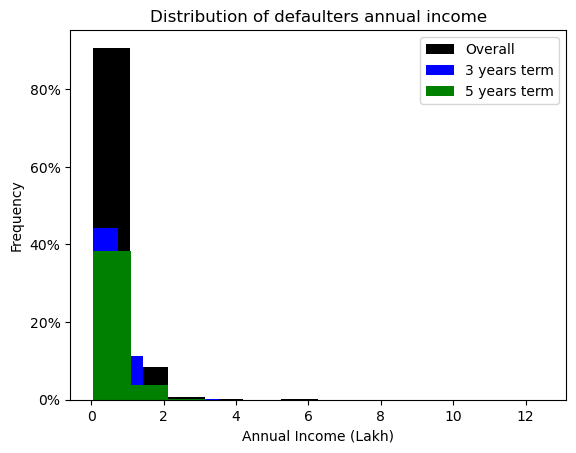

In [11]:
# Annual income of defaulters
# Get the annual income data of the defaulters
a_i = df_defaults['annual_inc']/1e05
# Bucketizing w.r.t term
a_i_36 = df_defaults[df_defaults['term'] == ' 36 months']['annual_inc']/1e05
a_i_60 = df_defaults[df_defaults['term'] == ' 60 months']['annual_inc']/1e05
# Draw the bar plots
a_i.plot.hist(bins=int(a_i.max()), color='k', label='Overall',weights=np.ones(len(a_i)) / len(a_i))
a_i_36.plot.hist(bins=int(a_i.max()), color='b', label='3 years term', weights=np.ones(len(a_i_36)) / len(a_i))
a_i_60.plot.hist(bins=int(a_i.max()), color='g', label='5 years term', weights=np.ones(len(a_i_60)) / len(a_i))
plt.legend()
plt.xlabel('Annual Income (Lakh)')
plt.title('Distribution of defaulters annual income')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Print the annual income statistics for each term
print(f"Overall annual income stats (lakhs): \n {a_i.describe()}")
print(f"3 years term annual income stats (lakhs): \n {a_i_36.describe()}")
print(f"5 years term annual income stats (lakhs): \n {a_i_36.describe()}")

### C.2.7 Loan purpose of defaulters

### Conclusions/Observations:
> - 50% of the defaulters have debt to be consolidated - this is clearly explainable by low income and higher loan requirements

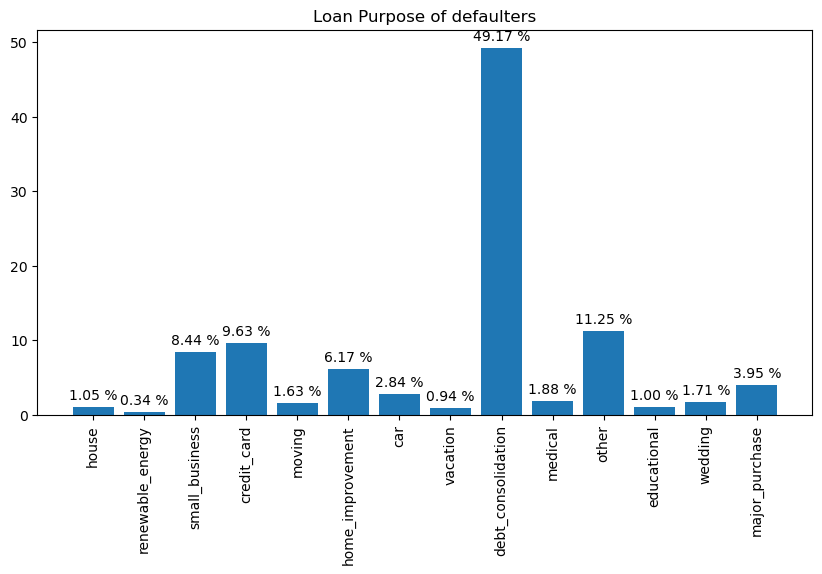

In [12]:
# purpose
# Get the data of loan purpose
p = df_defaults['purpose']
e = list(set(p.to_list()))
# Draw purpose distribution
plt.figure(figsize=(10, 5))
plot_pattern(e, 'purpose', len(df_defaults.index), "Loan Purpose of defaulters", df_defaults)
plt.xticks(rotation=90)
plt.show()

### C.2.8 DTI of defaulters

### Conclusions/Observations:
> - Most of the defaulters have DTI of about 14 which means monthly debt are 14 times more than total debt
obligations!
> - This again is supported by the fact that 50% of the defaulters are consolidating debts - see purpose section

count    5627.000000
mean       14.000624
std         6.585577
min         0.000000
25%         9.050000
50%        14.290000
75%        19.290000
max        29.850000
Name: dti, dtype: float64


<Axes: >

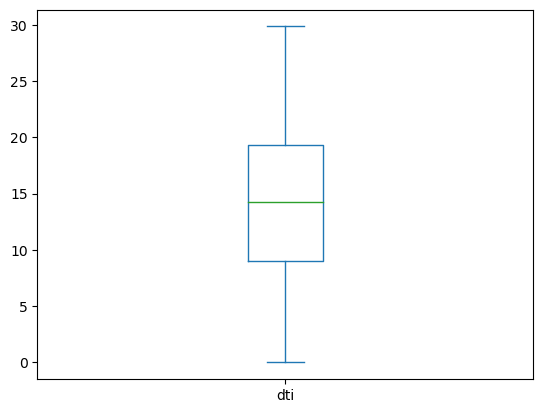

In [13]:
# dti
# Get the data of DTIs
a_dti = df_defaults['dti']
print(a_dti.describe())
# Plot the DTI statistics
a_dti.plot.box()

### C.2.9 Location distribution of defaulters

### Conclusions/Observations:
> - Almost 20% of the defaulters stay in California. 
> - Standard of living in CA is definitely higher as compared to other states!
> - High standard of living --> higher debt consolidation --> lower income --> Defaults!!

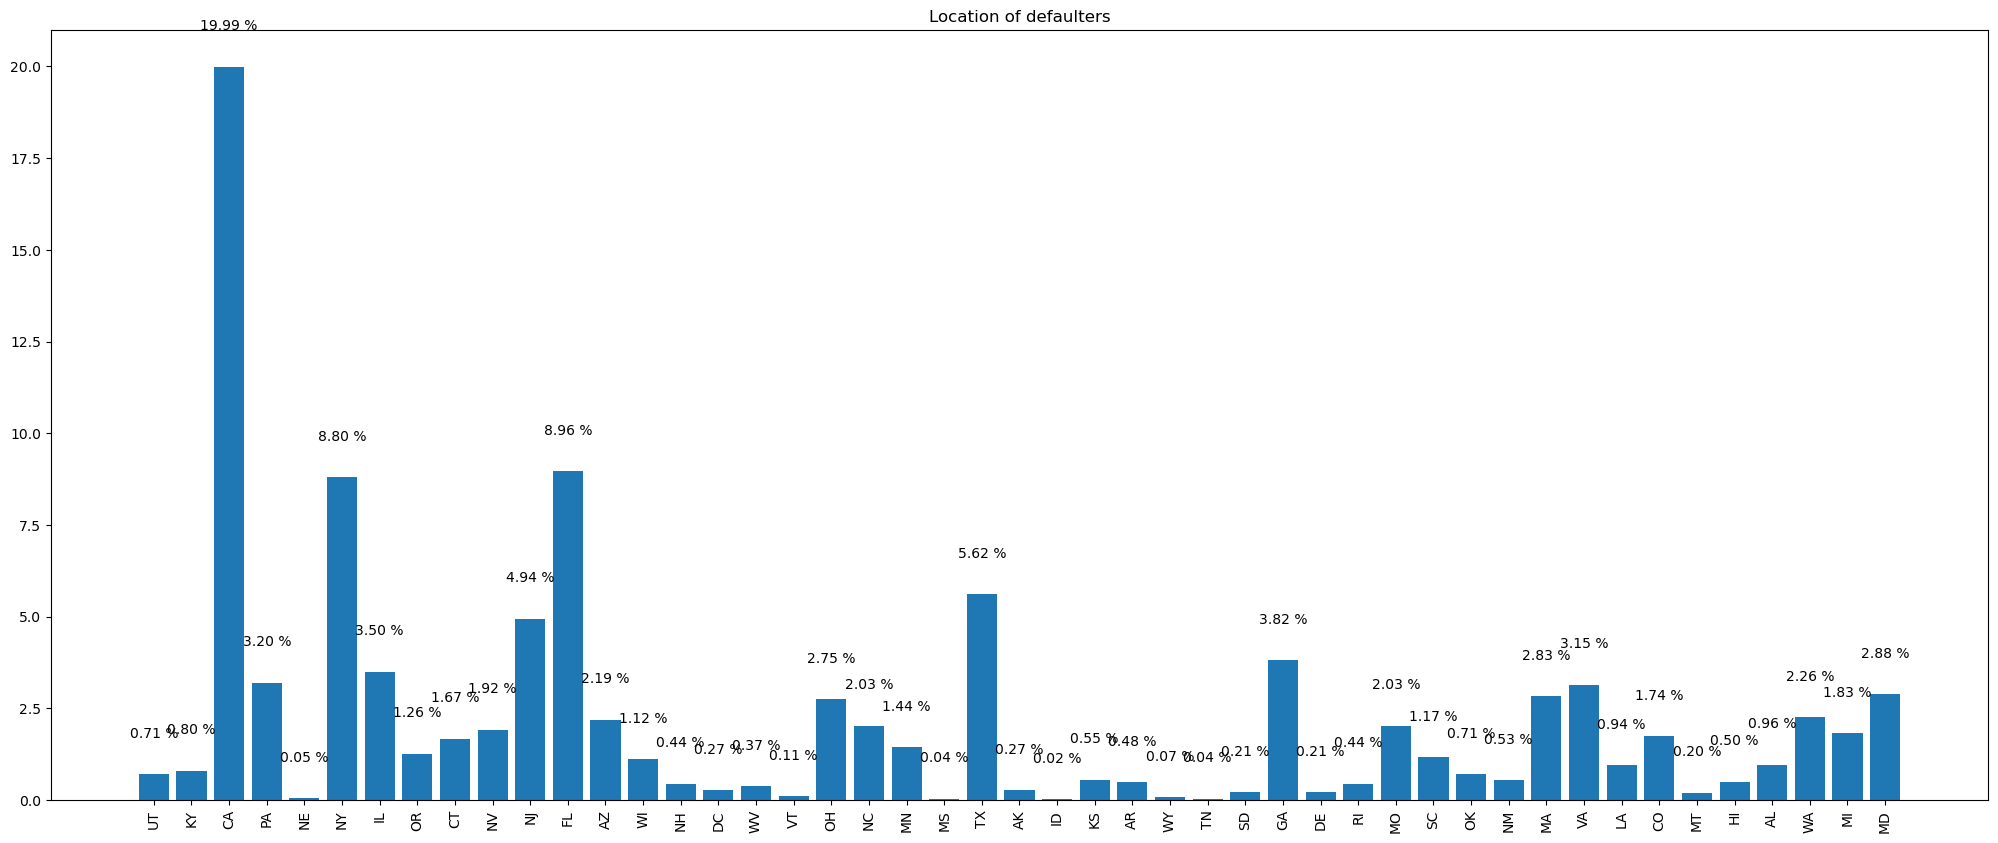

In [14]:
# where are the defaulters located
# Get the data of the defaulters' state address
addr_state = df_defaults['addr_state']
a = list(set(addr_state.to_list()))
# Plot the address statistics with bar plot
plt.figure(figsize=(25, 10))
plot_pattern(a, 'addr_state', len(df_defaults.index), "Location of defaulters", df_defaults)
plt.xticks(rotation=90)
plt.show()

### C.2.10 Interest rates of defaulters vs fully paid cases

### Conclusions/Observations:
> - On an average, defaulters have to pay loan with an interest rate of 14% p.a which is high considering lower income of the defaulters!

count       5627
unique       332
top       13.49%
freq         127
Name: int_rate, dtype: object


Text(0.5, 1.0, 'Interest Rates of Fully Paid')

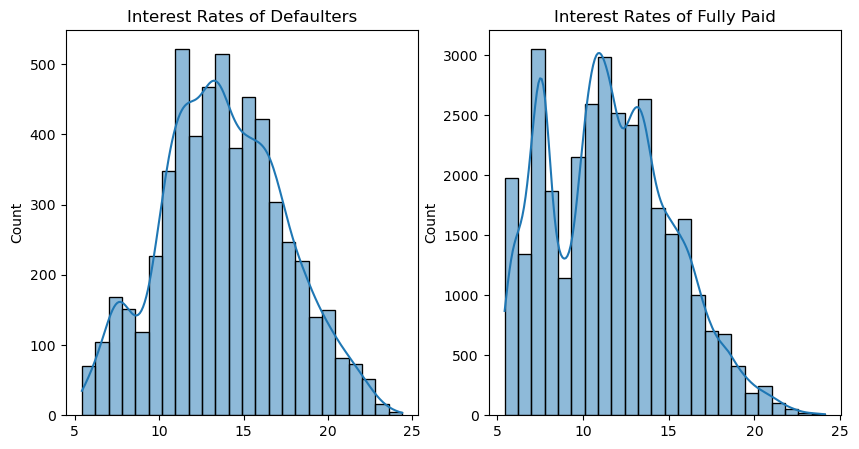

In [15]:
# Interest rates of defaulters
print(df_defaults['int_rate'].describe())
i_r = df_defaults['int_rate'].to_list()
i_r = [float(s.split('%')[0]) for s in i_r]
# Interest rates of the fully paid members
i_r_fp = df_fullyPaid['int_rate'].to_list()
i_r_fp = [float(s.split('%')[0]) for s in i_r_fp]
# Plot the interest rate statistics for defaulters and fully paid members
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.histplot(data=i_r, bins=int(max(i_r)), kde=True)
plt.title('Interest Rates of Defaulters')
plt.subplot(122)
sns.histplot(data=i_r_fp, bins=int(max(i_r_fp)), kde=True)
plt.title('Interest Rates of Fully Paid')

### C.2.11  Loan amount distribution of defaulters

### Conclusions/Observations:
> - For a 3 year term, most of the defaulters have a loan of Rs. 6000 with interest rate of 14%
> - For a 5 year term, the loan doubles i.e. becomes Rs. 12000 with interest rate of 14%
> - The variation/expanse of applied loan is more for a 5 year term with 1st quartile raised by almost Rs. 4000

3 years term Revolving Balance 
count     2435.000000
mean      6342.012320
std       3072.197094
min        900.000000
25%       4000.000000
50%       6000.000000
75%       9000.000000
max      12000.000000
Name: loan_amnt, dtype: float64
5 years term Revolving Balance 
count     1815.000000
mean     11845.358127
std       5324.796455
min       1000.000000
25%       7575.000000
50%      12000.000000
75%      16000.000000
max      21000.000000
Name: loan_amnt, dtype: float64


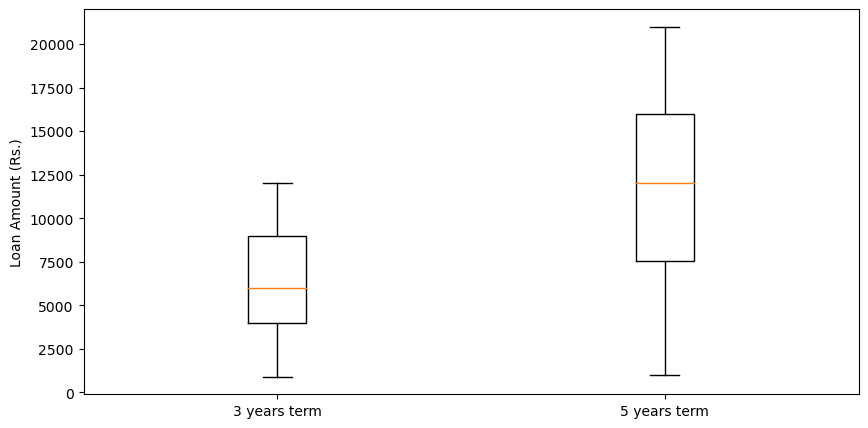

In [16]:
# Loan amount of defaulters
# Loan amount for 3 years term - remove the outliers (consider up to 75 percentile)
la_36 = df_defaults[df_defaults['term'] == ' 36 months']['loan_amnt']
la_36 = la_36[la_36 <= la_36.quantile(0.75)]
# Loan amount for 5 years term - remove the outliers (consider up to 75 percentile)
la_60 = df_defaults[df_defaults['term'] == ' 60 months']['loan_amnt']
la_60 = la_60[la_60 <= la_60.quantile(0.75)]
# Plot loan amount statistics
plt.figure(figsize=(10, 5))
plt.boxplot([la_36, la_60])
plt.xticks([1, 2], ['3 years term', '5 years term'])
plt.ylabel('Loan Amount (Rs.)')
print(f"3 years term Revolving Balance \n{la_36.describe()}")
print(f"5 years term Revolving Balance \n{la_60.describe()}")

### C.2.12 Overdue behavior of defaulters vs fully paid cases

### Conclusions/Observations:
> - It can be clearly seen that the defaulters have not paid any loan installment lately
> - Larger difference in the last payment date and issue date indicates that more number of loan installments have been paid off by the fully paid cases
> - Lesser difference for the defaulters clearly indicate less number of installments paid till date!
> - Assuming last payment date as the loan repayment completion for fully paid cases
    - For the 3 years term, defaulters have not paid off the installments since last 2 years!!
    - Similarly for 5 years term, defaulters have not paid off the installments since last 3-3.5 years!!

            date_diff
term                 
 36 months   1.429898
 60 months   1.928985
            date_diff
term                 
 36 months   2.362024
 60 months   3.135470


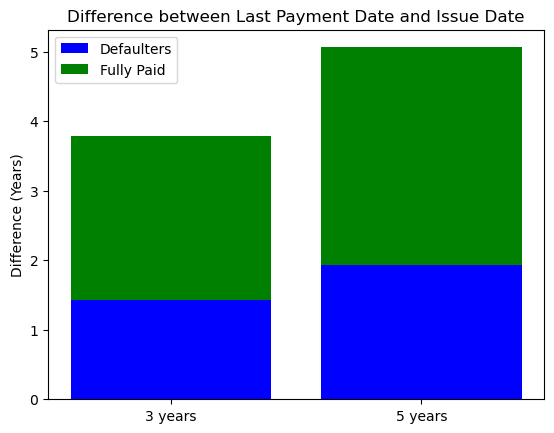

In [19]:
# Bucketizing (Last payment date - Issue date)
df_d = get_term_wise_mean_date_diff(df_defaults)
df_fp_d = get_term_wise_mean_date_diff(df_fullyPaid)
d_1 = df_d['date_diff'].to_list()
d_2 = df_fp_d['date_diff'].to_list()
# Plot date difference statistics
plt.bar(x=['3 years', '5 years'], height=d_1, color='b', label='Defaulters')
plt.bar(x=['3 years', '5 years'], height=d_2, color='g', bottom=d_1, label='Fully Paid')
plt.legend()
plt.ylabel('Difference (Years)')
plt.title('Difference between Last Payment Date and Issue Date')
print(df_d)
print(df_fp_d)

### C.2.13 Revolving balance stats of defaulters

### Conclusions/Observations:
> - For a 3 years term, most of the defaulters still have the revolving balance of around Rs. 5600 which is pretty close to the loan amount itself (Rs. 6000)
> - For a 5 years term, most of the defaulters still have the revolving balance of around Rs. 7800 which is pretty close to the loan amount itself (Rs. 12000)


3 years term Revolving Balance 
count     2420.000000
mean      6209.497521
std       4456.798290
min          0.000000
25%       2321.750000
50%       5598.500000
75%       9619.250000
max      15833.000000
Name: revol_bal, dtype: float64
5 years term Revolving Balance 
count     1801.000000
mean      8311.816768
std       5560.460082
min          0.000000
25%       3422.000000
50%       7817.000000
75%      12819.000000
max      19619.000000
Name: revol_bal, dtype: float64


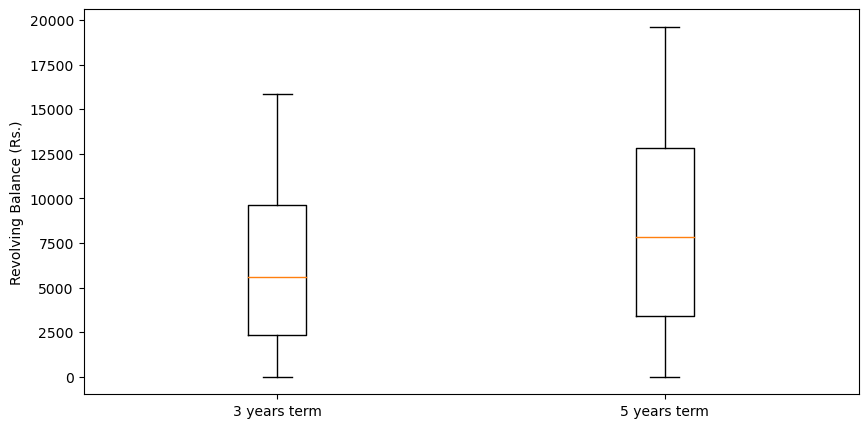

In [18]:
# Total revolving account 
# For 3 years term - remove outliers (consider up to 75 percentile)
a_rb_36 = df_defaults[df_defaults['term'] == ' 36 months']['revol_bal']
a_rb_36 = a_rb_36[a_rb_36 <= a_rb_36.quantile(0.75)]
# For 5 years term - remove outliers (consider up to 75 percentile)
a_rb_60 = df_defaults[df_defaults['term'] == ' 60 months']['revol_bal']
a_rb_60 = a_rb_60[a_rb_60 <= a_rb_60.quantile(0.75)]
# Plot revolving account statistics
plt.figure(figsize=(10, 5))
plt.boxplot([a_rb_36, a_rb_60])
plt.xticks([1, 2], ['3 years term', '5 years term'])
plt.ylabel('Revolving Balance (Rs.)')
print(f"3 years term Revolving Balance \n{a_rb_36.describe()}")
print(f"5 years term Revolving Balance \n{a_rb_60.describe()}")